In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
from time import time

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

# Load CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,
                                             download=True,
                                             transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='data/',
                                            train=False,
                                            download=True,
                                            transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()
model.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
# Define dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# # Define model
# model = MyModel()

# # Move model to device
# model = model.to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


In [10]:
# Set number of GPUs
num_gpus = torch.cuda.device_count()

# Use data parallelism
if num_gpus > 1:
    model = torch.nn.DataParallel(model)

In [12]:
num_epochs = 2

In [13]:
# Train model
for epoch in range(num_epochs):
    for inputs, labels in train_dataloader:
        # Move inputs and labels to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()



In [18]:
def model_training(net, epochs):
    t1 = time()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            # inputs, labels = data
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
                
    t2=time()
    print('Finished Training'+ ' took ' + str(t2-t1))
    return running_loss, t2-t1

In [19]:
model_training(model,4)

Finished Training took 42.38906502723694


(1797.4068274497986, 42.38906502723694)

In [38]:
from trainer import Trainer
from visualizer import *

In [43]:
# trainer
num_epochs = 2
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_dataloader=train_dataloader,
                  validation_dataloader=test_dataloader,
                  lr_scheduler=None,
                  epochs=num_epochs,
                  epoch=0,
                  notebook=True)

# start training
training_losses, validation_losses, lr_rates, training_times = trainer.run_trainer()

Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

In [44]:
vals

([1.980527493502478, 1.9528829054454404],
 [1.9646309075082184, 1.9406867444894875],
 [0.001, 0.001],
 [12.669604539871216, 12.2398099899292])

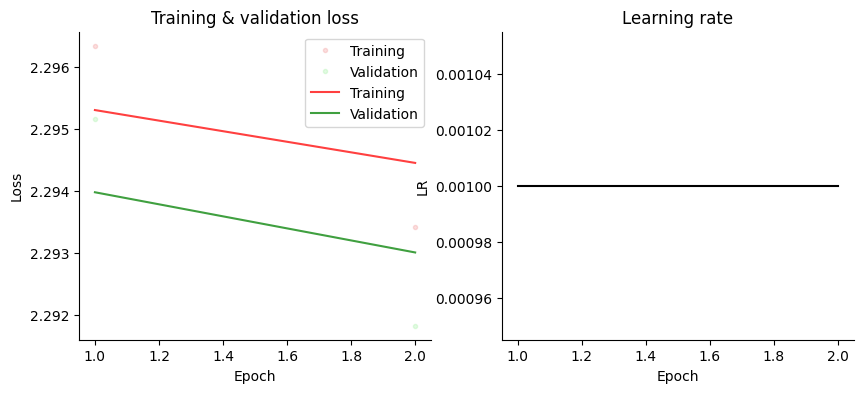

In [29]:
fig = plot_training(training_losses,
    validation_losses,
    lr_rates,
    gaussian=True,
    sigma=1,
    figsize=(10, 4),
)

In [42]:
from typing import Optional

import numpy as np
import torch
from torch.utils.data import Dataset
from time import time


class Trainer:
    def __init__(
        self,
        model: torch.nn.Module,
        device: torch.device,
        criterion: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        training_dataloader: Dataset,
        validation_dataloader: Optional[Dataset] = None,
        lr_scheduler = None,
        epochs: int = 100,
        epoch: int = 0,
        notebook: bool = False,
    ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_dataloader = training_dataloader
        self.validation_dataloader = validation_dataloader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook

        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []
        self.training_time = []

    def run_trainer(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        progressbar = trange(self.epochs, desc="Progress")
        for i in progressbar:
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_dataloader is not None:
                self._validate()

            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                if (
                    self.validation_dataloader is not None
                    and self.lr_scheduler.__class__.__name__ == "ReduceLROnPlateau"
                ):
                    self.lr_scheduler.batch(
                        self.validation_loss[i]
                    )  # learning rate scheduler step with validation loss
                else:
                    self.lr_scheduler.batch()  # learning rate scheduler step
        return self.training_loss, self.validation_loss, self.learning_rate, self.training_time

    def _train(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange
            
        t1 = time()

        self.model.train()  # train mode
        train_losses = []  # accumulate the losses here
        batch_iter = tqdm(
            enumerate(self.training_dataloader),
            "Training",
            total=len(self.training_dataloader),
            leave=False,
        )

        for i, (x, y) in batch_iter:
            input_x, target_y = x.to(self.device), y.to(
                self.device
            )  # send to device (GPU or CPU)
            self.optimizer.zero_grad()  # zerograd the parameters
            out = self.model(input_x)  # one forward pass
            loss = self.criterion(out, target_y)  # calculate loss
            loss_value = loss.item()
            train_losses.append(loss_value)
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters
            

            batch_iter.set_description(
                f"Training: (loss {loss_value:.4f})"
            )  # update progressbar
            
        t2 = time()

        self.training_loss.append(np.mean(train_losses))
        self.training_time.append(t2-t1)
        self.learning_rate.append(self.optimizer.param_groups[0]["lr"])

        batch_iter.close()

    def _validate(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.eval()  # evaluation mode
        valid_losses = []  # accumulate the losses here
        batch_iter = tqdm(
            enumerate(self.validation_dataloader),
            "Validation",
            total=len(self.validation_dataloader),
            leave=False,
        )

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(
                self.device
            )  # send to device (GPU or CPU)

            with torch.no_grad():
                out = self.model(input)
                loss = self.criterion(out, target)
                loss_value = loss.item()
                valid_losses.append(loss_value)

                batch_iter.set_description(f"Validation: (loss {loss_value:.4f})")

        self.validation_loss.append(np.mean(valid_losses))

        batch_iter.close()